# 프로젝트: 뉴스기사 요약해보기 

* 목표: 추상적 요약과 추출적 요약을 할 수 있다.

- 학습목표
    * Extractive/Abstractive summarization 이해하기
    * 단어장 크기를 줄이는 다양한 text normalization 적용해보기
    * seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기


- 프로젝트 구현 순서 
    * Attentional Seq2Seq를 활용한 추상적 요약하기 
        * 데이터 수집하기 
        * 데이터 전처리하기 
            - 중복 샘플과 Null값 제거 
            - 텍스트 정규화
            - 불용어 제거 
            - 데이터 Split 
            - 샘플의 최대 길이 정하기 
            - 시작, 종료 토큰 추가 
            - 단어집합 생성 및 정수 인코딩 
            - 패딩 
        * 모델 설계하기 
        * 어텐션 메커니즘 사용하기 
            - 모델 훈련하기 
            - 인퍼런스 모델 훈련하기 
            - 모델 테스트 하기 
        * 실제 결과와 요약문 비교하기 
    * Summa를 이용한 추출적 요약하기 

In [109]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import wget

from tqdm import tqdm

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import requests
from summa.summarizer import summarize

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj19/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 데이터 수집하기 
(수정사항) 기존에 있던 requests 라이브러리를 활용하면 인터넷이 끊기거나 했을때, 실행마다 에러가 발생할 수 있어 wget을 활용해서 로컬에 다운받았습니다. 

In [110]:
url = "https://raw.githubusercontent.com/sunnysai12345/News_headlines/master/news_headlines_more.csv"

data_path = os.getenv("HOME")+'/aiffel/news_summarization/data/news_headlines_more.csv'

if not os.path.isfile(data_path):
    wget.download(url, out = data_path)

else:
    print("data가 이미 존재합니다.")

data가 이미 존재합니다.


In [111]:
news_data = pd.read_csv(data_path, encoding='iso-8859-1')
print('전체 샘플수 :',(len(news_data)))

전체 샘플수 : 98401


In [112]:
news_data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


data라는 데이터프레임을 살펴보면 뉴스 요약봇을 만들기 위해 사용할 수 있는 컬럼은 text열과 해당 열의 내용을 요약한 headlines열입니다. 인공 신경망을 통해 text 시퀀스를 입력받으면, headlines 시퀀스를 예측하도록 인공신경망을 훈련시킬 것입니다. 

In [113]:
tmp = news_data[['headlines','text']]
tmp.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [114]:
#랜덤한 15개 샘플 출력
tmp.sample(15)

,headlines,text
94069,Guinness attempt for highest bike ride blocked...,A Cuban cyclist's Guinness World Record attemp...
53769,Journalism student murdered by mob named Pak P...,A journalism student at Abdul Wali Khan Univer...
75575,Firm that falsely claimed it was linked to Goo...,"UK-based Movette, which falsely claimed to be ..."
78965,Delhi Police share Bollywood-inspired memes on...,Delhi Police have been using Bollywood-inspire...
69434,"Plane crashes into tree, pilot survives and wa...",Video footage has captured the moment a plane ...
61735,App to remind old people of medicine schedules...,Mobile app called 'Dawai Dost' has been develo...
35940,Ex-Google employee's startup valued at $15 bil...,Ex-Google employee Colin Huang's e-commerce si...
7467,"Cleartrip fires 100 in India, focuses on Middl...",Online booking platform Cleartrip has fired ne...
27175,Rihanna changed my destiny: Indian model on re...,Talking about her supposed resemblance to sing...
21394,Indonesia's richest man to participate in Asia...,Billionaire tobacco tycoon Michael Bambang Har...


In [115]:
del news_data
news_data = tmp

news_data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## 데이터 전처리하기 - 추상적 요약 
텍스트를 정규화 또는 정제합니다. <br> 
(생각해볼 포인트) 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을까? <br> 
그렇지 않을 수 있고, 상대적으로 불용어를 전부 제거하면, 요약이라는 프로젝트 특성상에 좋은 영향이 미치지 않을 수 있습니다. 해당 부분은 기존의 뉴스 요약봇이 어떤식으로 불용어 제거를 하고 있는 지 확인했습니다. 요약문에서는 굳이 불용어를 제거하는 것이 좋지 않기 때문에 짧은 문장인 요약문에서는 불용어 제거를 건너뛰었습니다. 

In [117]:
data = news_data
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [119]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [120]:
# 중복 샘플 제거 
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [121]:
print('null 개수: ', data.isnull().sum())

null 개수:  headlines    0
text         0
dtype: int64


In [122]:
# 데이터프레임에서의 null값 제거 
data.dropna(axis = 0, inplace = True)
print('null 개수: ', data.isnull().sum())
print('전체 샘플수 :',(len(data)))

null 개수:  headlines    0
text         0
dtype: int64
전체 샘플수 : 98360


### 텍스트 정규화와 불용어 제거
정규화를 통해 기계적 연산량을 줄여줍니다. 

In [123]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


from nltk.corpus import stopwords에서 nltk에 있는 말뭉치의 불용어 리스트를 참고합니다.

In [124]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 headlines 전처리할 때는 호출하지 않을 예정이에요. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 headlines에는 남아 있는게 더 좋을 것 같습니다. 

In [125]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [126]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


이때, text의 경우에는 불용어를 제거하고, headlines의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행합니다. 먼저 text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력합니다. <br>
**한번 수행한 후에 그 값들을 csv로 저장해둡니다.**

In [128]:
# clean_text = []

# # 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
# for s in tqdm(data['text']):
#     clean_text.append(preprocess_sentence(s))

# clean_headlines = []

# # 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
# for s in tqdm(data['headlines']):
#     clean_headlines.append(preprocess_sentence(s, False))

100%|██████████| 98360/98360 [00:17<00:00, 5590.07it/s]


In [129]:
# # 전처리 후 출력
# clean_text[:5]
# clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [130]:
# data['text'] = clean_text
# data['headlines'] = clean_headlines

# # 빈 값을 Null 값으로 변환
# data.replace('', np.nan, inplace=True)

In [131]:
project_path = os.getenv("HOME")+"/aiffel/news_summarization/"

In [132]:
data['text'].to_csv(project_path + 'clean_text.csv')
data['headlines'].to_csv(project_path + 'clean_headlines.csv')

저장해둔 clean_text와 clean_headlines를 불러옵니다. 

In [133]:
tmp = pd.read_csv(project_path + 'clean_text.csv', encoding='iso-8859-1')
tmp.head()

,Unnamed: 0,text
0,0,saurav kant alumnus upgrad iiit pg program mac...
1,1,kunal shah credit card bill payment platform c...
2,2,new zealand defeated india wickets fourth odi ...
3,3,aegon life iterm insurance plan customers enjo...
4,4,speaking sexual harassment allegations rajkuma...


In [134]:
data['text'] = tmp['text']
data['text'].head()

0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: text, dtype: object

In [135]:
tmp = pd.read_csv(project_path + 'clean_headlines.csv', encoding='iso-8859-1')
tmp.head()

,Unnamed: 0,headlines
0,0,upgrad learner switches to career in ml al wit...
1,1,delhi techie wins free food from swiggy for on...
2,2,new zealand end rohit sharma led india match w...
3,3,aegon life iterm insurance plan helps customer...
4,4,have known hirani for yrs what if metoo claims...


In [136]:
data['headlines'] = tmp['headlines']
data['headlines'].head()

0    upgrad learner switches to career in ml al wit...
1    delhi techie wins free food from swiggy for on...
2    new zealand end rohit sharma led india match w...
3    aegon life iterm insurance plan helps customer...
4    have known hirani for yrs what if metoo claims...
Name: headlines, dtype: object

In [137]:
data.isnull().sum()

headlines    41
text         41
dtype: int64

In [138]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98319


### 훈련데이터와 테스트데이터 나누기
#### 샘플의 최대 길이 정하기

In [139]:
data.head()

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.0997670846937
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.29977928986259


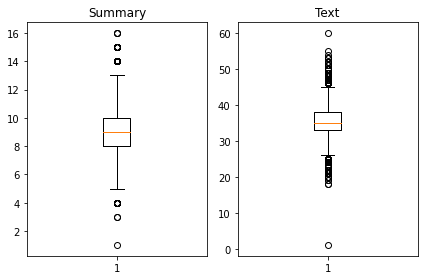

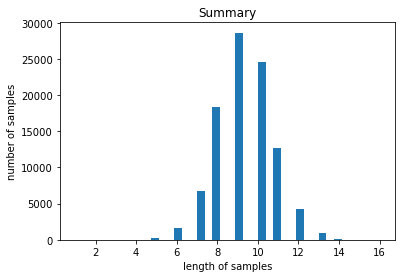

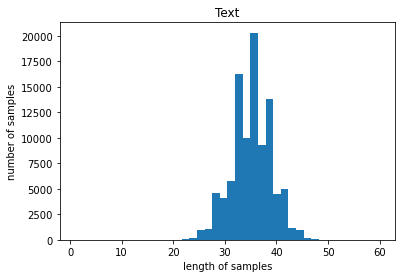

In [140]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 결과에서 요약의 최대길이는 16이나, 실제적으로 평균은 4로 12까지의 값들이 몰려서 분포하고 있음을 알 수 있습니다. <br>
또한 text에서는 평균은 35로 60보다 작은 값들에 분포가 몰려있음을 알 수 있었습니다. 따라서, 위의 분포를 확인했을때 임의적으로 각각의 max_len을 요약 특성과, 분포 특성을 기반으로 하여 35과 13으로 맞추겠습니다. 35길이를 가지는 문장을 받고, 13길이를 가지는 요약문으로 끊어낸다고 판단하겠습니다. 

In [159]:
text_max_len = 37
headlines_max_len = 13

In [160]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [161]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 37 이하인 샘플의 비율: 0.7986216614923927
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981064359160666


In [162]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 72392


(시도 사항) 본문이 원래 짧으면 상관없지만, 요약문이 너무 짧은 경우엔 정확도에 부정적인 영향을 미칠 수 있으므로 삭제하겠습니다. <br>
(결과) 너무 많은 데이터가 날라갔습니다. 5만개에서 약 1만개정도 데이터가 남아서 해당 사항을 적용해주지 않았습니다. 

In [163]:
# data = data[data['headlines'].apply(lambda x: len(x.split()) >= 2)]
# print('전체 샘플수 :',(len(data)))

#### 시작 토큰과 종료 토큰 추가하기

In [164]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [165]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [166]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[23345 37042 17801 ... 66450 52281 40970]


In [167]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [168]:
n_of_val = int(len(encoder_input)*0.1)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 7239


In [169]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 65153
훈련 레이블의 개수 : 65153
테스트 데이터의 개수 : 7239
테스트 레이블의 개수 : 7239


#### 단어 집합(vocaburary) 만들기 및 정수 인코딩
이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어있어요. 

In [170]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

등장 빈도수가 8회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요. src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요.

In [175]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 60993
등장 빈도가 7번 이하인 희귀 단어의 수: 42927
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18066
단어 집합에서 희귀 단어의 비율: 70.38020756480252
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.320420965036076


등장 빈도가 7회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 18066으로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 15000으로 제한합니다. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있습니다. 

In [176]:
src_vocab = 15000 # 8000 to 15000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000 to 15000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행합니다. 현재 단어 집합의 크기를 11,000으로 제한했으니까 이제 11,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않게 됩니다.

In [177]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[32, 477, 117, 11493, 6173, 7310, 64, 6854, 386, 3140, 4, 660, 278, 24, 11493, 2, 316, 386, 2094, 111, 363, 50, 955, 133, 85, 1347, 11493, 166, 671, 1148, 759, 1825], [158, 16, 70, 203, 295, 182, 4876, 3579, 574, 1501, 6639, 423, 339, 31, 177, 2456, 16, 662, 1003, 566, 2699, 323, 9, 295, 3579, 4114, 423, 30, 3, 16, 55, 295, 1774, 423], [928, 787, 705, 1136, 3115, 9429, 9430, 8282, 3098, 187, 13312, 206, 214, 5042, 3541, 8283, 9430, 3080, 7438, 370, 1656, 2372, 6965, 7809, 12787, 3950, 13858, 8283, 5707, 3098]]


headlines 데이터에 대해서도 동일한 작업을 수행합니다.. 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산합니다.

In [178]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인합니다. 

In [180]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27362
등장 빈도가 4번 이하인 희귀 단어의 수: 16988
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10374
단어 집합에서 희귀 단어의 비율: 62.08610481689934
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.375959346079907


등장 빈도가 4회 이하인 단어들은 단어 집합에서 약 62%를 차지하고있네요. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 4.37%정도 입니다. 요약도 아까와 같이 희귀 단어를 제외한 단어 집합의 크기를 참고해서 단어집합의 크기를 지정합니다. 

In [181]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 40, 5369, 141, 5668, 429, 289, 7836, 7837], [1, 4209, 302, 7, 7838, 970, 4, 246, 63, 3, 673], [1, 715, 4745, 7266, 3, 274, 1455, 103], [1, 99, 19, 3141, 5, 53, 155, 1435, 2602, 5129, 40, 1867, 724], [1, 49, 98, 187, 12, 170, 14, 56, 283, 660]]
target
decoder  [[40, 5369, 141, 5668, 429, 289, 7836, 7837, 2], [4209, 302, 7, 7838, 970, 4, 246, 63, 3, 673, 2], [715, 4745, 7266, 3, 274, 1455, 103, 2], [99, 19, 3141, 5, 53, 155, 1435, 2602, 5129, 40, 1867, 724, 2], [49, 98, 187, 12, 170, 14, 56, 283, 660, 2]]


전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있습니다. 이 현상은 길이가 상대적으로 길었던 원문(text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(headlines)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 큽니다.<br>
여기서 주의할 점은 요약문인 decoder_input에는 sos token 또는 decoder_target에는 eos token이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제 되지 않습니다. 그래서 이제 길이가 0이 된 요약문의 실제길이는 1로 나올거에요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아있을겁니다. <br>
훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장하고 모두 삭제하겠습니다.

In [182]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 65152
훈련 레이블의 개수 : 65152
테스트 데이터의 개수 : 7239
테스트 레이블의 개수 : 7239


#### 패딩하기
최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [183]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## 모델 설계하기

In [184]:
# 인코더 설계 시작
embedding_dim = 128 # 128 to 64
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야겠죠? 디코더를 설계해볼게요!

In [185]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일해요. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요. 디코더의 출력층을 설계해볼게요.

In [187]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 37, 128)      1920000     input_9[0][0]                    
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, 37, 256), (N 394240      embedding_5[0][0]                
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

## 어텐션 메커니즘 사용하기 - 추상적 요약
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [188]:
url = "https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py"

library_path = os.getenv("HOME")+'/aiffel/news_summarization/attention.py'

if not os.path.isfile(library_path):
    wget.download(url, out = library_path)

else:
    print("library가 이미 존재합니다.")

library가 이미 존재합니다.


In [61]:
from attention import AttentionLayer

In [190]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 37, 128)      1920000     input_9[0][0]                    
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, 37, 256), (N 394240      embedding_5[0][0]                
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기
실험적으로 확인했을때, epochs는 20회차 주변에서 멈추는 것을 확인해서 epochs는 기존 50에서 30으로 줄였습니다. 

In [191]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history =  model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 30)

Epoch 1/30
255/255 [==============================] - 85s 333ms/step - loss: 5.1143 - val_loss: 4.7155
Epoch 2/30
255/255 [==============================] - 83s 324ms/step - loss: 4.6069 - val_loss: 4.3900
Epoch 3/30
255/255 [==============================] - 83s 327ms/step - loss: 4.2935 - val_loss: 4.1329
Epoch 4/30
255/255 [==============================] - 85s 334ms/step - loss: 4.0580 - val_loss: 3.9703
Epoch 5/30
255/255 [==============================] - 86s 336ms/step - loss: 3.8713 - val_loss: 3.8317
Epoch 6/30
255/255 [==============================] - 86s 337ms/step - loss: 3.7192 - val_loss: 3.7436
Epoch 7/30
255/255 [==============================] - 86s 337ms/step - loss: 3.5886 - val_loss: 3.6667
Epoch 8/30
255/255 [==============================] - 85s 335ms/step - loss: 3.4736 - val_loss: 3.5943
Epoch 9/30
255/255 [==============================] - 87s 341ms/step - loss: 3.3706 - val_loss: 3.5490
Epoch 10/30
255/255 [==============================] - 83s 327ms/step - l

In [192]:
model.save(project_path + 'my_model')

INFO:tensorflow:Assets written to: /home/aiffel-dj19/aiffel/news_summarization/my_model/assets


In [193]:
from tensorflow.keras import models

save_model = models.load_model(project_path + 'my_model')

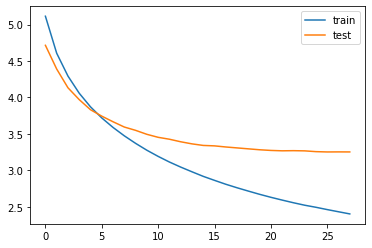

In [194]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 훈련하기 
seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야합니다. 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비합니다. 그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [195]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [196]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [197]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [198]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트하기 

In [199]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

In [200]:
for i in range(100, 110):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : london based institute public policy research announced cash prize radical ideas boost uk economic growth think tank said prize believed third biggest international economics announcement comes week official predicted uk grow faster next five years 
실제 요약 : lakh prize offered for ideas to solve weak uk growth 
예측 요약 :  uk to host its own award for nobel


원문 : google completed billion deal electronics company htc google acquired part htc engineering design teams deal also includes employees worked google pixel smartphones announced september last year also included non exclusive license htc intellectual property 
실제 요약 : google completes billion deal to buy engineers from 
예측 요약 :  google to invest billion in google retail market


원문 : year old dalit boy allegedly assaulted sporting moustache gujarat village staged attack garner publicity police probe revealed investigators failed find weapon perpetrators alleged assault upon questioning boy confessed inflicted wounds along two s

## Summa을 이용하기 - 추출적 요약
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 어렵습니다. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮습니다. Summarize 모듈을 활용하면 추출적 요약을 할 수 있습니다. <br>
해당 라이브러리는 내부적으로 토큰화를 진행하므로 토큰화된 문장을 넣어주면 동작이 제대로 결과를 내놓지 못합니다. 그래서 토큰화되지 않은 상태로 입력 문장을 줍니다. 
* text (str) : 요약할 테스트.
* ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
* words (int or None, optional) – 출력에 포함할 단어 수. 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
* split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [220]:
news_data = pd.read_csv(data_path, encoding='iso-8859-1')
news_data['text'].head()

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
Name: text, dtype: object

In [212]:
text = news_data['text'][1]
print(text[:])

Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [213]:
print(len(text))

347


In [214]:
print(len(text.split(" ")))

60


In [215]:
print('headlines:')
print(summarize(text, ratio=0.5))

headlines:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [216]:
print('headlines:')
print(summarize(text, ratio=0.5, split=True))

headlines:
['Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.']


In [217]:
print('headlines:')
print(summarize(text, words=20))

headlines:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


#### 추상적 요약과 추출적 요약 비교하기
다른 데이터를 넣어줌으로써 비교해보면 추상적 요약은 문장에서 사용된 데이터로만 예측 요약이 이뤄지지 않는 점을 알 수 있습니다. 추출적 요약은 입력 문장에 의존적이지만, 추상적 요약은 상대적으로 자유롭습니다. <br> 
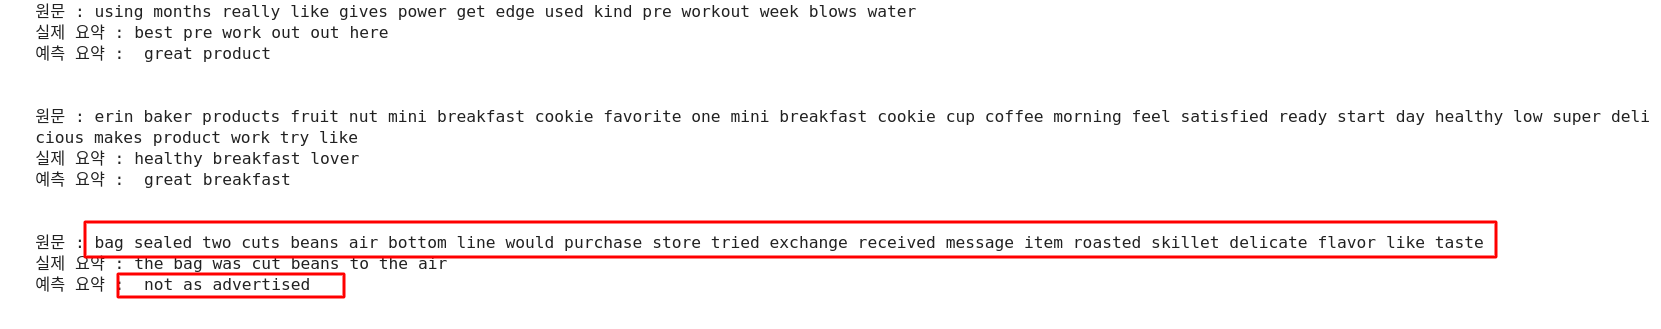

In [237]:
for i in range(202, 205):
    print(">> 원문 :", seq2text(encoder_input_test[i]))
    print(">> 실제 요약 :", seq2headlines(decoder_input_test[i]))
    print(">> 예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

>> 원문 : year old man monday approached delhi hc seeking police protection wife year old son alleged alcohol addict claimed son harassing paying daily expenses alcohol court directed police file report regard allegations 
>> 실제 요약 : yr old delhi man seeks protection from alcohol addict son 
>> 예측 요약 :  delhi man booked for killing wife in wife


>> 원문 : nasa shared image wildfires california us killed least people wildfires erupted kilometres north california thursday destroyed homes several commercial buildings fire officials estimate lakh people evacuated homes due wildfires 
>> 실제 요약 : nasa shares image of california wildfires from space 
>> 예측 요약 :  nasa opens us hurricane irma in california hurricane


>> 원문 : passengers reportedly fainted suffered panic attacks friday thailand australia flight runway two hours air stopped working passenger claimed people continued scream open doors decision made let passengers flight delayed day passengers provided accommodation 
>> 실제 요약 : passen

추출적 요약 같은 경우 입력 문장에 담겨있는 단어와 ratio, words의 인자를 바탕으로 내부적으로 토큰화를 수행한 후 요약이 진행되기 때문에 입력 문장에 의존적입니다. 또한 어떤 문맥상의 중요성을 기준으로 잡아 특정 문장쪽에 중심되어 요약되는 경우가 더 많습니다. <br>
다만 문장을 그대로 추출하는 경우가 많아 추상적 요약에 비해 문법적 오류는 적었습니다. 
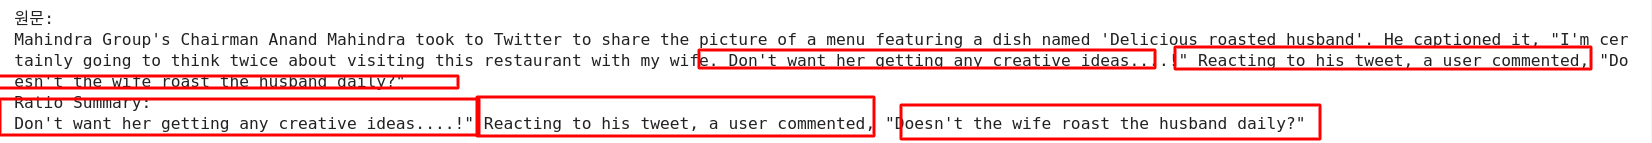

In [229]:
headlines = news_data['headlines']

In [236]:
for i in range(n_of_val + 202, n_of_val + 205):
    t_headlines = headlines[i]
    print('>> 정답 요약문:')
    print(t_headlines)
    print('-------------------------------------------------------------')

>> 정답 요약문:
Tata Motors shares plunge 4% after S&P rating downgrade
-------------------------------------------------------------
>> 정답 요약문:
May use FordÃ¢ÂÂs US plants to build cars: Volkswagen CEO
-------------------------------------------------------------
>> 정답 요약문:
Cash-strapped Faraday Future sends some staff on unpaid leave
-------------------------------------------------------------


In [231]:
text = news_data['text']

In [235]:
for i in range(n_of_val + 202, n_of_val + 205):
    t_text = text[i]
    print('>> 원문:')
    print(t_text)
    print('>> Ratio headlines:')
    print(summarize(t_text, ratio=0.4))
    print('-------------------------------------------------------------')

>> 원문:
Shares of Tata Motors on Wednesday plunged as much as 4% after S&P Global Ratings downgraded the credit rating of the automaker and its British arm Jaguar Land Rover (JLR). The rating was downgraded citing weak profitability at JLR. In November, MoodyÃ¢ÂÂs had changed the automaker's rating outlook to negative from stable, citing expectations of JLR's weak operating performance.
>> Ratio headlines:
The rating was downgraded citing weak profitability at JLR.
-------------------------------------------------------------
>> 원문:
Volkswagen CEO Herbert Diess on Tuesday said the German automaker was building an alliance with Ford Motor and might use the US automaker's plants to build cars. Speaking after a meeting at the White House, he also said the company may build a second plant in the US. Volkswagen is "in quite advanced negotiations" with Ford, he further said.
>> Ratio headlines:
Volkswagen CEO Herbert Diess on Tuesday said the German automaker was building an alliance with F

# 루브릭 

1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다. <br>
✅ 분석단계
✅ 정제단계
✅ 정규화와 불용어 제거
✅ 데이터셋 분리
✅ 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
2. 텍스트 요약 모델이 성공적으로 학습되었음을 확인하였다. <br>
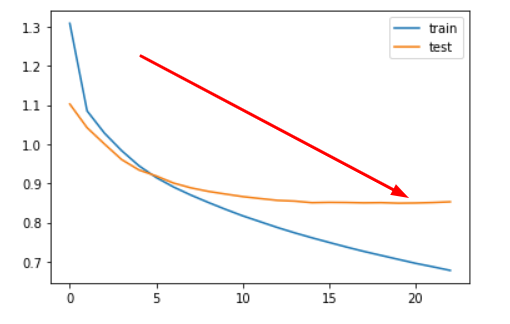 <br>
✅ 모델 학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다. <br>
✅ 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

## 회고 
1. 어려웠던 점 
어텐션에 대한 개념은 이해했으나, 코드상에서 어텐션 메커니즘이 적용된 디코더 파트가 이해가 덜 되었습니다. 그리고 디코더의 입력부로 들어가는 연산과정에 대해 Seq2seq를 다시 살펴볼 필요성을 느꼈습니다. <br>

2. 프로젝트 난이도  
프로젝트를 하면서 이전에 해왔던 프로젝트에 있던 자연어 처리 프로젝트를 다시 상기시킬 수 있어서 좋았습니다. 실제로 이전 프로젝트할때 이번 노드 작성자 분의 위키독스를 많이 참고했었는데, 구성이 비슷해 프로젝트에서 전처리나 모델 설계 부분을 제외하고는 이해하기 쉬웠습니다. 

3. 프로젝트하면서 마주한 오류나 실수 
일단 이번 프로젝트는 저번 네이버 영화리뷰와 큰 흐름의 차이없이 코딩해서 코딩에서의 오류는 없었습니다. 다만, 데이터셋에 대한 부분을 잘못 파악해서 모두 학습한 후에 재학습하는 .. 상황이 되었었습니다. 데이터셋을 잘 확인하자..는 다짐을 하게되었습니다.

4. 프로젝트 하면서..  
수희님께서 올려주신 질문이지만, 요약에 대한 결과를 평가하는 것이 어떤 기준으로 가능할까? 하는 부분이 좀 어려운 부분이라고 생각됩니다. 이전에 논문 라벨링 구축에 참여한 적이 있는데 텍스트 데이터들도 앞으로 이미지처럼 라벨링된 데이터가 활성화되면 사람보다 요약을 잘하는 요약봇이 등장하지 않을까 하는 생각이 들었습니다. 추후 해커톤에서 자연어 데이터셋도 잘 만들어보면서? 프로젝트를 진행해보고 싶다는 생각이 들었습니다.  